In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_32_1 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 1
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_32_1[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 18.285305976867676 
    loop_MC 1 - time has passed: 81.27655863761902 
    loop_MC 2 - time has passed: 143.79825925827026 
    loop_MC 3 - time has passed: 203.27678751945496 
    loop_MC 4 - time has passed: 261.58945631980896 
    loop_MC 5 - time has passed: 321.8796977996826 
    loop_MC 6 - time has passed: 379.255646944046 
    loop_MC 7 - time has passed: 443.49808049201965 
    loop_MC 8 - time has passed: 493.51327633857727 
    loop_MC 9 - time has passed: 549.3911046981812 
    loop_MC 10 - time has passed: 614.6223142147064 
    loop_MC 11 - time has passed: 672.2955179214478 
    loop_MC 12 - time has passed: 731.6549956798553 
    loop_MC 13 - time has passed: 792.5995290279388 
    loop_MC 14 - time has passed: 842.2983391284943 
    loop_MC 15 - time has passed: 906.4851975440979 
    loop_MC 16 - time has passed: 945.5865547657013 
    loop_MC 17 - time has passed: 1008.5460667610168 
    loop_MC 18 - time has passed: 1060.66501593589

    loop_MC 2 - time has passed: 174.19869184494019 
    loop_MC 3 - time has passed: 236.08519530296326 
    loop_MC 4 - time has passed: 291.5205867290497 
    loop_MC 5 - time has passed: 353.04066252708435 
    loop_MC 6 - time has passed: 412.7966101169586 
    loop_MC 7 - time has passed: 463.888507604599 
    loop_MC 8 - time has passed: 517.341475725174 
    loop_MC 9 - time has passed: 582.0111467838287 
    loop_MC 10 - time has passed: 642.5539388656616 
    loop_MC 11 - time has passed: 697.679328918457 
    loop_MC 12 - time has passed: 757.6333332061768 
    loop_MC 13 - time has passed: 808.1777505874634 
    loop_MC 14 - time has passed: 868.6226744651794 
    loop_MC 15 - time has passed: 935.9690463542938 
    loop_MC 16 - time has passed: 998.9662449359894 
    loop_MC 17 - time has passed: 1037.791396856308 
    loop_MC 18 - time has passed: 1090.1619710922241 
    loop_MC 19 - time has passed: 1149.8279583454132 
    loop_MC 20 - time has passed: 1199.3918001651764

    loop_MC 4 - time has passed: 272.68684911727905 
    loop_MC 5 - time has passed: 327.0868589878082 
    loop_MC 6 - time has passed: 385.29652547836304 
    loop_MC 7 - time has passed: 438.1906387805939 
    loop_MC 8 - time has passed: 499.412406206131 
    loop_MC 9 - time has passed: 548.0420184135437 
    loop_MC 10 - time has passed: 608.2303493022919 
    loop_MC 11 - time has passed: 656.3899075984955 
    loop_MC 12 - time has passed: 714.1062030792236 
    loop_MC 13 - time has passed: 774.6334483623505 
    loop_MC 14 - time has passed: 829.0107316970825 
    loop_MC 15 - time has passed: 882.4696633815765 
    loop_MC 16 - time has passed: 944.6391706466675 
    loop_MC 17 - time has passed: 987.9430387020111 
    loop_MC 18 - time has passed: 1048.4983129501343 
    loop_MC 19 - time has passed: 1113.2749481201172 
    loop_MC 20 - time has passed: 1160.4171259403229 
    loop_MC 21 - time has passed: 1216.8580129146576 
    loop_MC 22 - time has passed: 1269.56198668

    loop_MC 5 - time has passed: 342.1576249599457 
    loop_MC 6 - time has passed: 400.4237470626831 
    loop_MC 7 - time has passed: 453.15428376197815 
    loop_MC 8 - time has passed: 509.13864493370056 
    loop_MC 9 - time has passed: 570.9548881053925 
    loop_MC 10 - time has passed: 628.2840359210968 
    loop_MC 11 - time has passed: 687.8345456123352 
    loop_MC 12 - time has passed: 742.0092899799347 
    loop_MC 13 - time has passed: 793.7419180870056 
    loop_MC 14 - time has passed: 850.9032185077667 
    loop_MC 15 - time has passed: 916.6200723648071 
    loop_MC 16 - time has passed: 974.3528482913971 
    loop_MC 17 - time has passed: 1030.8265235424042 
    loop_MC 18 - time has passed: 1089.503254890442 
    loop_MC 19 - time has passed: 1147.6285643577576 
    loop_MC 20 - time has passed: 1208.6546382904053 
    loop_MC 21 - time has passed: 1267.943367242813 
    loop_MC 22 - time has passed: 1327.7449498176575 
    loop_MC 23 - time has passed: 1391.250530

    loop_MC 7 - time has passed: 423.5371239185333 
    loop_MC 8 - time has passed: 476.1118185520172 
    loop_MC 9 - time has passed: 535.2367401123047 
    loop_MC 10 - time has passed: 582.2428350448608 
    loop_MC 11 - time has passed: 646.6338012218475 
    loop_MC 12 - time has passed: 708.4960262775421 
    loop_MC 13 - time has passed: 767.2003934383392 
    loop_MC 14 - time has passed: 826.149222612381 
    loop_MC 15 - time has passed: 886.4674608707428 
    loop_MC 16 - time has passed: 949.8040821552277 
    loop_MC 17 - time has passed: 999.3299973011017 
    loop_MC 18 - time has passed: 1056.8699114322662 
    loop_MC 19 - time has passed: 1114.4873116016388 
    loop_MC 20 - time has passed: 1168.3414447307587 
    loop_MC 21 - time has passed: 1226.0683171749115 
    loop_MC 22 - time has passed: 1281.1448709964752 
    loop_MC 23 - time has passed: 1348.2297551631927 
    loop_MC 24 - time has passed: 1414.0833973884583 
    loop_MC 25 - time has passed: 1469.5146

    loop_MC 9 - time has passed: 556.0793969631195 
    loop_MC 10 - time has passed: 604.6822023391724 
    loop_MC 11 - time has passed: 672.7508990764618 
    loop_MC 12 - time has passed: 723.1598958969116 
    loop_MC 13 - time has passed: 790.8055982589722 
    loop_MC 14 - time has passed: 842.739883184433 
    loop_MC 15 - time has passed: 897.164520740509 
    loop_MC 16 - time has passed: 959.8747918605804 
    loop_MC 17 - time has passed: 1012.4150588512421 
    loop_MC 18 - time has passed: 1073.2962129116058 
    loop_MC 19 - time has passed: 1133.9893231391907 
    loop_MC 20 - time has passed: 1191.030030965805 
    loop_MC 21 - time has passed: 1256.4244720935822 
    loop_MC 22 - time has passed: 1316.561588525772 
    loop_MC 23 - time has passed: 1373.9393637180328 
    loop_MC 24 - time has passed: 1432.0695476531982 
    loop_MC 25 - time has passed: 1493.70574426651 
    loop_MC 26 - time has passed: 1543.8395991325378 
    loop_MC 27 - time has passed: 1605.9058

    loop_MC 11 - time has passed: 680.8493895530701 
    loop_MC 12 - time has passed: 731.3353064060211 
    loop_MC 13 - time has passed: 799.1040458679199 
    loop_MC 14 - time has passed: 866.9762976169586 
    loop_MC 15 - time has passed: 924.086608171463 
    loop_MC 16 - time has passed: 979.1048784255981 
    loop_MC 17 - time has passed: 1025.2198762893677 
    loop_MC 18 - time has passed: 1084.8737862110138 
    loop_MC 19 - time has passed: 1148.3885185718536 
    loop_MC 20 - time has passed: 1212.6917700767517 
    loop_MC 21 - time has passed: 1273.7558498382568 
    loop_MC 22 - time has passed: 1325.5873601436615 
    loop_MC 23 - time has passed: 1388.424230337143 
    loop_MC 24 - time has passed: 1436.6543221473694 
    loop_MC 25 - time has passed: 1489.626071214676 
    loop_MC 26 - time has passed: 1551.8883810043335 
    loop_MC 27 - time has passed: 1606.9112312793732 
    loop_MC 28 - time has passed: 1673.043329000473 
    loop_MC 29 - time has passed: 1737

    loop_MC 13 - time has passed: 761.4622786045074 
    loop_MC 14 - time has passed: 821.1456944942474 
    loop_MC 15 - time has passed: 877.1926817893982 
    loop_MC 16 - time has passed: 931.181675195694 
    loop_MC 17 - time has passed: 988.3407158851624 
    loop_MC 18 - time has passed: 1049.9537720680237 
    loop_MC 19 - time has passed: 1103.7474236488342 
    loop_MC 20 - time has passed: 1166.9539804458618 
    loop_MC 21 - time has passed: 1229.9930365085602 
    loop_MC 22 - time has passed: 1287.8145153522491 
    loop_MC 23 - time has passed: 1347.9951615333557 
    loop_MC 24 - time has passed: 1411.540601491928 
    loop_MC 25 - time has passed: 1479.6884789466858 
    loop_MC 26 - time has passed: 1535.0580041408539 
    loop_MC 27 - time has passed: 1588.3218228816986 
    loop_MC 28 - time has passed: 1646.94087266922 
    loop_MC 29 - time has passed: 1709.6865892410278 
    loop_MC 30 - time has passed: 1763.3959465026855 
    loop_MC 31 - time has passed: 181

    loop_MC 14 - time has passed: 867.7181828022003 
    loop_MC 15 - time has passed: 924.2505843639374 
    loop_MC 16 - time has passed: 984.9447281360626 
    loop_MC 17 - time has passed: 1050.4863121509552 
    loop_MC 18 - time has passed: 1116.242377281189 
    loop_MC 19 - time has passed: 1172.8056976795197 
    loop_MC 20 - time has passed: 1225.5214846134186 
    loop_MC 21 - time has passed: 1276.675138950348 
    loop_MC 22 - time has passed: 1337.5791289806366 
    loop_MC 23 - time has passed: 1385.4885385036469 
    loop_MC 24 - time has passed: 1442.6012706756592 
    loop_MC 25 - time has passed: 1501.402629852295 
    loop_MC 26 - time has passed: 1554.3459627628326 
    loop_MC 27 - time has passed: 1617.9644737243652 
    loop_MC 28 - time has passed: 1679.7386717796326 
    loop_MC 29 - time has passed: 1732.991634607315 
    loop_MC 30 - time has passed: 1781.042363166809 
    loop_MC 31 - time has passed: 1842.5146617889404 
    loop_MC 32 - time has passed: 18

    loop_MC 16 - time has passed: 946.8615257740021 
    loop_MC 17 - time has passed: 1005.3459467887878 
    loop_MC 18 - time has passed: 1060.8348178863525 
    loop_MC 19 - time has passed: 1111.7997903823853 
    loop_MC 20 - time has passed: 1172.2747123241425 
    loop_MC 21 - time has passed: 1229.3850193023682 
    loop_MC 22 - time has passed: 1289.587572813034 
    loop_MC 23 - time has passed: 1353.4586029052734 
    loop_MC 24 - time has passed: 1404.1551313400269 
    loop_MC 25 - time has passed: 1458.6651020050049 
    loop_MC 26 - time has passed: 1516.1721732616425 
    loop_MC 27 - time has passed: 1572.4292345046997 
    loop_MC 28 - time has passed: 1631.1847665309906 
    loop_MC 29 - time has passed: 1683.0201904773712 
    loop_MC 30 - time has passed: 1749.9800667762756 
    loop_MC 31 - time has passed: 1806.9465155601501 
    loop_MC 32 - time has passed: 1861.9338171482086 
    loop_MC 33 - time has passed: 1918.8474507331848 
    loop_MC 34 - time has pass

    loop_MC 17 - time has passed: 979.4424042701721 
    loop_MC 18 - time has passed: 1038.8611469268799 
    loop_MC 19 - time has passed: 1103.2305595874786 
    loop_MC 20 - time has passed: 1153.327330827713 
    loop_MC 21 - time has passed: 1216.6256120204926 
    loop_MC 22 - time has passed: 1275.8277609348297 
    loop_MC 23 - time has passed: 1337.2493970394135 
    loop_MC 24 - time has passed: 1397.7091705799103 
    loop_MC 25 - time has passed: 1461.9407544136047 
    loop_MC 26 - time has passed: 1510.0882663726807 
    loop_MC 27 - time has passed: 1556.937652349472 
    loop_MC 28 - time has passed: 1617.2376339435577 
    loop_MC 29 - time has passed: 1675.326108455658 
    loop_MC 30 - time has passed: 1742.7273807525635 
    loop_MC 31 - time has passed: 1811.5653240680695 
    loop_MC 32 - time has passed: 1864.3169803619385 
    loop_MC 33 - time has passed: 1915.189206123352 
    loop_MC 34 - time has passed: 1973.192403793335 
    loop_MC 35 - time has passed: 

    loop_MC 19 - time has passed: 1107.326738357544 
    loop_MC 20 - time has passed: 1164.3920650482178 
    loop_MC 21 - time has passed: 1220.4628183841705 
    loop_MC 22 - time has passed: 1275.156442642212 
    loop_MC 23 - time has passed: 1331.1421387195587 
    loop_MC 24 - time has passed: 1394.069842338562 
    loop_MC 25 - time has passed: 1450.7792687416077 
    loop_MC 26 - time has passed: 1504.3171710968018 
    loop_MC 27 - time has passed: 1562.6372928619385 
    loop_MC 28 - time has passed: 1619.852793931961 
    loop_MC 29 - time has passed: 1679.2298066616058 
    loop_MC 30 - time has passed: 1740.0774431228638 
    loop_MC 31 - time has passed: 1806.2347648143768 
    loop_MC 32 - time has passed: 1861.1186487674713 
    loop_MC 33 - time has passed: 1919.687497138977 
    loop_MC 34 - time has passed: 1980.2046058177948 
    loop_MC 35 - time has passed: 2036.451432466507 
    loop_MC 36 - time has passed: 2092.9582562446594 
    loop_MC 37 - time has passed: 

    loop_MC 21 - time has passed: 1224.5653083324432 
    loop_MC 22 - time has passed: 1270.230268239975 
    loop_MC 23 - time has passed: 1334.0120203495026 
    loop_MC 24 - time has passed: 1384.0931026935577 
    loop_MC 25 - time has passed: 1451.4542546272278 
    loop_MC 26 - time has passed: 1513.1334829330444 
    loop_MC 27 - time has passed: 1577.3068192005157 
    loop_MC 28 - time has passed: 1629.7351241111755 
    loop_MC 29 - time has passed: 1689.7229878902435 
    loop_MC 30 - time has passed: 1748.6482906341553 
    loop_MC 31 - time has passed: 1803.1970853805542 
    loop_MC 32 - time has passed: 1851.3871347904205 
    loop_MC 33 - time has passed: 1912.3960001468658 
    loop_MC 34 - time has passed: 1971.3796956539154 
    loop_MC 35 - time has passed: 2030.7566878795624 
    loop_MC 36 - time has passed: 2085.207233428955 
    loop_MC 37 - time has passed: 2154.7889878749847 
    loop_MC 38 - time has passed: 2209.9393384456635 
    loop_MC 39 - time has pass

    loop_MC 23 - time has passed: 1202.3449988365173 
    loop_MC 24 - time has passed: 1253.6487929821014 
    loop_MC 25 - time has passed: 1303.4125666618347 
    loop_MC 26 - time has passed: 1353.3645679950714 
    loop_MC 27 - time has passed: 1400.3205835819244 
    loop_MC 28 - time has passed: 1445.9256706237793 
    loop_MC 29 - time has passed: 1495.0520570278168 
    loop_MC 30 - time has passed: 1543.9415836334229 
    loop_MC 31 - time has passed: 1592.6471545696259 
    loop_MC 32 - time has passed: 1642.1401326656342 
    loop_MC 33 - time has passed: 1694.758648633957 
    loop_MC 34 - time has passed: 1749.1164016723633 
    loop_MC 35 - time has passed: 1800.4562220573425 
    loop_MC 36 - time has passed: 1847.1739990711212 
    loop_MC 37 - time has passed: 1898.3635504245758 
    loop_MC 38 - time has passed: 1944.0007021427155 
    loop_MC 39 - time has passed: 1997.8378958702087 
    loop_MC 40 - time has passed: 2050.6923093795776 
    loop_MC 41 - time has pas

    loop_MC 24 - time has passed: 1138.0337100028992 
    loop_MC 25 - time has passed: 1190.358493089676 
    loop_MC 26 - time has passed: 1246.5901265144348 
    loop_MC 27 - time has passed: 1293.6997706890106 
    loop_MC 28 - time has passed: 1341.6864349842072 
    loop_MC 29 - time has passed: 1394.9168710708618 
    loop_MC 30 - time has passed: 1445.1806709766388 
    loop_MC 31 - time has passed: 1495.0824933052063 
    loop_MC 32 - time has passed: 1545.0644512176514 
    loop_MC 33 - time has passed: 1593.4547815322876 
    loop_MC 34 - time has passed: 1646.519407749176 
    loop_MC 35 - time has passed: 1705.2797989845276 
    loop_MC 36 - time has passed: 1762.6702673435211 
    loop_MC 37 - time has passed: 1813.0430207252502 
    loop_MC 38 - time has passed: 1862.8388068675995 
    loop_MC 39 - time has passed: 1916.5610888004303 
    loop_MC 40 - time has passed: 1966.8710098266602 
    loop_MC 41 - time has passed: 2020.9114654064178 
    loop_MC 42 - time has pass

    loop_MC 25 - time has passed: 1025.3219909667969 
    loop_MC 26 - time has passed: 1064.814611196518 
    loop_MC 27 - time has passed: 1103.7714517116547 
    loop_MC 28 - time has passed: 1143.3868656158447 
    loop_MC 29 - time has passed: 1182.2036986351013 
    loop_MC 30 - time has passed: 1221.1784965991974 
    loop_MC 31 - time has passed: 1261.06982254982 
    loop_MC 32 - time has passed: 1299.8434040546417 
    loop_MC 33 - time has passed: 1337.6204164028168 
    loop_MC 34 - time has passed: 1376.8582561016083 
    loop_MC 35 - time has passed: 1415.2195570468903 
    loop_MC 36 - time has passed: 1454.5950844287872 
    loop_MC 37 - time has passed: 1492.5365920066833 
    loop_MC 38 - time has passed: 1531.4208998680115 
    loop_MC 39 - time has passed: 1570.8756573200226 
    loop_MC 40 - time has passed: 1610.5207209587097 
    loop_MC 41 - time has passed: 1651.1742587089539 
    loop_MC 42 - time has passed: 1692.0905230045319 
    loop_MC 43 - time has passe

In [6]:
print(i_beta_32_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


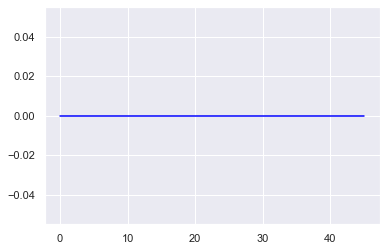

In [7]:
plt.plot(i_beta_32_1, color='blue')

In [8]:
scio.savemat('./i_beta_32_1.mat', {'i_beta_32_1': i_beta_32_1})